## Ejercicio 3

In [2]:
import cirq

In [137]:
import matplotlib.pyplot as plt

def plot_histogram(result: dict) -> None:
    
    counts = sorted(result.items(), key=lambda x: x[0])
    keys = [str(x[0]) for x in counts]
    values = [x[1] for x in counts]
    plt.bar_label(plt.bar(keys, [x / 1000 for x in values]), values)

### QFT

Vamos a implementar el sumador de Draper de 4 bits usando el circuito de la QFT del ejercicio anterior.

Para ello vamos a usar la función que definimos anteriormente.

In [3]:
def QFT(qubits):

    N = len(qubits)
    circuit = cirq.Circuit()

    for i in range(N):
        circuit.append(cirq.H(qubits[i]))
        for j in range(i + 1, N):
            circuit.append(cirq.CZ(qubits[j], qubits[i])**(0.5**(j-i)))

    return circuit

Vamos a definir una función que nos cree la parte intermedia del sumador de Draper.

El circuito consiste en aplicar rotaciones controladas entre los distintos qubits de cada uno de los operandos.

In [34]:
def adder(qubits):
    
    N = len(qubits) // 2
    circuit = cirq.Circuit()

    for i in range(N):
        for j in range(i, N):
            circuit.append(cirq.CZ(qubits[N + j], qubits[i])**(0.5**(j-i)))

    return circuit

# Probamos la función para 2 qubits.
print(adder(cirq.LineQubit.range(2*2)))

0: ───@───@───────────
      │   │
1: ───┼───┼───────@───
      │   │       │
2: ───@───┼───────┼───
          │       │
3: ───────@^0.5───@───


Vemos que la función crea el circuito correctamente.

Ahora, para crear el sumador, vamos a conectar el circuito de la QFT, luego el del sumador, y finalmente la QFT inversa. Vamos a emplear 8 bits: el primer operando seran los qubits 0:3, y el segundo los qubits 4:7.

In [156]:
# Número de qubits de cada operando
N = 4

A = 0b0011  # Primer operando (3)
B = 0b1001   # Segundo operando (9)

qubits = cirq.LineQubit.range(2*N)
circuit = cirq.Circuit()

# Inicializamos los qubits opreando al valor que deseamos.
for i in range(N):
    
    if ((A >> N - i - 1) & 0x1) == 1:
        circuit.append(cirq.X(qubits[i]))

    if (B >> N - i - 1 & 0x1) == 1:
        circuit.append(cirq.X(qubits[N + i]))

qft_circ = QFT(qubits[:N])
circuit.append(qft_circ)

circuit.append(adder(qubits))
circuit.append(cirq.inverse(qft_circ))

# Medimos unicamente los qubits 0:3, que son los que contienen A+B
for qubit in qubits[:N]:
    circuit.append(cirq.measure(qubit))

El resultado de la suma debería salir por los qubits 0:3, mientras que los qubits 4:7 no deberían verse alterados (Se hace esto para mantener la reversibilidad del circuito). Por esto, vamos a medir únicamente los cuatro primeros qubits.

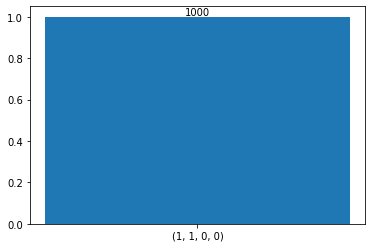

In [157]:
results = cirq.Simulator().run(circuit, repetitions=1000).multi_measurement_histogram(keys=qubits[:N])

plot_histogram(results)

Hemos sumado 9+3, y vemos que en asuencia de ruido, se ha medido el resultado 12 el 100% de las ejecuciones, por lo que el sumador funciona correctamete.